## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm, t, kstest, binom
import time

## Import Dataset

In [2]:

# Parameters
startDate = dt.datetime(2011, 2, 1)
endDate = dt.datetime.now()
tickers = ['^NSMIDCP', '^NSEBANK', '^CNXIT', '^CNXFMCG']
portfolio_value = 1000000
confidence_interval = 0.99
days = 50
lookback_period = 500
simulations = 10000

# Import Dataset
adj_close_df = yf.download(tickers, start=startDate, end=endDate)['Adj Close']
log_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()



[*********************100%%**********************]  4 of 4 completed


## Create Equally Weighted Portfolio Returns

In [3]:
# Create Equally Weighted Portfolio Returns
weights = np.array([1 / len(tickers)] * len(tickers))
historical_returns = (log_returns * weights).sum(axis=1)
rolling_50day_returns = historical_returns.rolling(window=days).sum().dropna()


## Historical VAR Calculation

In [4]:
# Historical VAR Calculation
def calculate_historical_var(returns, confidence_level, portfolio_value):
    var = -np.percentile(returns, 100 * (1 - confidence_level))
    return portfolio_value * var

VaR_historical = calculate_historical_var(rolling_50day_returns, confidence_interval, portfolio_value)



## Parametric Method

In [5]:
from scipy.stats import norm

# Parametric Method
def calculate_parametric_var(returns, confidence_level, days, portfolio_value, lookback_period):
    recent_returns = returns.iloc[-lookback_period:]
    _, p_value = kstest(recent_returns, 'norm')
    
    if p_value < 0.05:  # Not normally distributed
        df, _, _ = t.fit(recent_returns)
        var = t.ppf(confidence_level, df) * recent_returns.std() * np.sqrt(days)
    else:  # Normally distributed
        var = norm.ppf(confidence_level) * recent_returns.std() * np.sqrt(days)
    
    return portfolio_value * var

VaR_parametric = calculate_parametric_var(historical_returns, confidence_interval, days, portfolio_value, lookback_period)


## Monte Carlo Method

In [6]:
# Monte Carlo Method
def improved_monte_carlo_var(returns, weights, confidence_level, days, portfolio_value, simulations=10000):
    cov_matrix = returns.cov() * days
    mean_returns = returns.mean() * days
    
    L = np.linalg.cholesky(cov_matrix)
    
    sim_returns = np.random.normal(size=(len(weights), simulations))
    sim_returns = mean_returns.values.reshape(-1, 1) + L @ sim_returns
    portfolio_sim_returns = weights @ sim_returns
    
    var = -np.percentile(portfolio_sim_returns, 100 * (1 - confidence_level))
    return portfolio_value * var

VaR_monte_carlo = improved_monte_carlo_var(log_returns, weights, confidence_interval, days, portfolio_value)


## Plotting all 3 methods

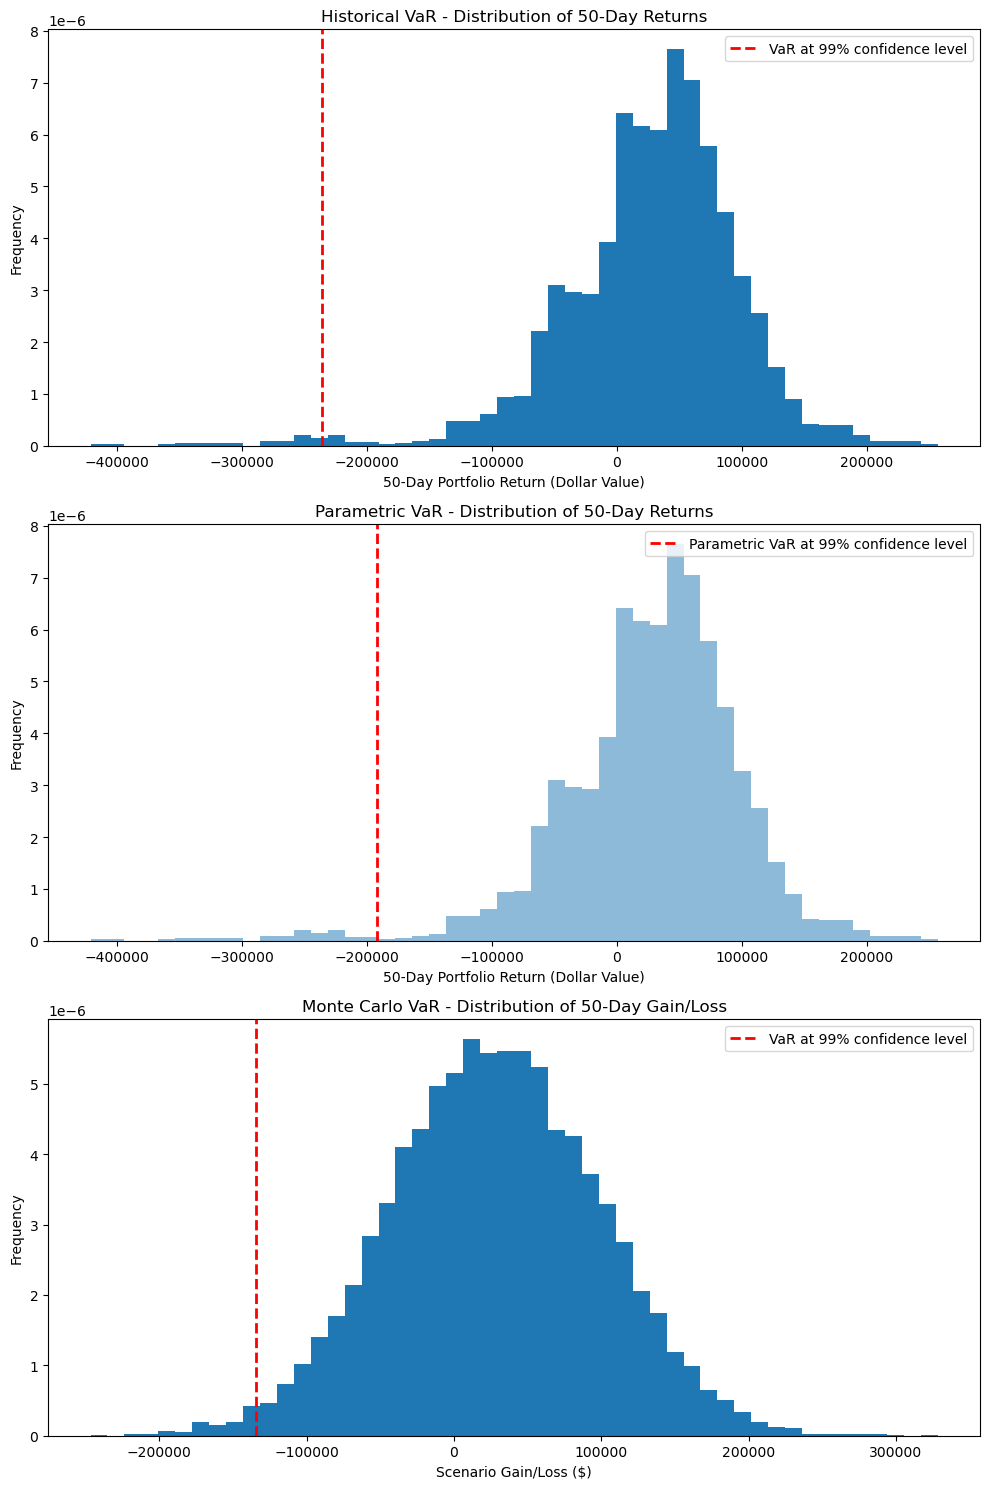

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting all VaR methods
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot Historical VaR
range_returns_dollar = rolling_50day_returns * portfolio_value
ax[0].hist(range_returns_dollar, bins=50, density=True)
ax[0].axvline(-VaR_historical, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
ax[0].set_title(f'Historical VaR - Distribution of {days}-Day Returns')
ax[0].set_xlabel(f'{days}-Day Portfolio Return (Dollar Value)')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Plot Parametric VaR
historical_x_day_returns_dollar = historical_returns.rolling(window=days).sum().dropna() * portfolio_value
ax[1].hist(historical_x_day_returns_dollar, bins=50, density=True, alpha=0.5)
ax[1].axvline(-VaR_parametric, color='r', linestyle='dashed', linewidth=2, label=f'Parametric VaR at {confidence_interval:.0%} confidence level')
ax[1].set_title(f'Parametric VaR - Distribution of {days}-Day Returns')
ax[1].set_xlabel(f'{days}-Day Portfolio Return (Dollar Value)')
ax[1].set_ylabel('Frequency')
ax[1].legend()

# Plot Monte Carlo VaR
# Generate scenario returns for Monte Carlo plot
scenario_returns = np.random.normal(
    loc=historical_returns.mean() * days,
    scale=historical_returns.std() * np.sqrt(days),
    size=simulations
) * portfolio_value

ax[2].hist(scenario_returns, bins=50, density=True)
ax[2].axvline(-VaR_monte_carlo, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
ax[2].set_title(f'Monte Carlo VaR - Distribution of {days}-Day Gain/Loss')
ax[2].set_xlabel('Scenario Gain/Loss ($)')
ax[2].set_ylabel('Frequency')
ax[2].legend()

plt.tight_layout()
plt.show()

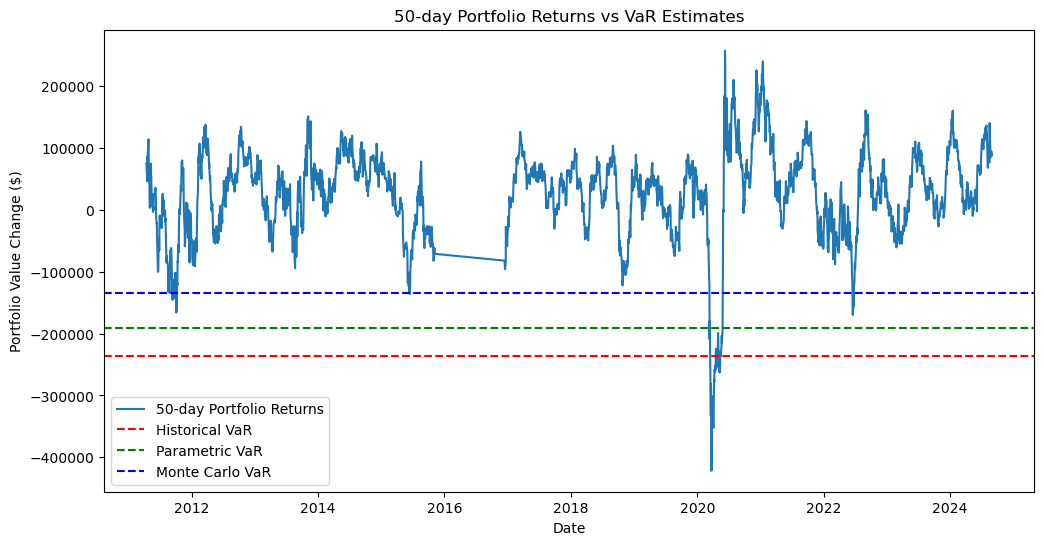

In [10]:
# Plotting all 3 methods
plt.figure(figsize=(12, 6))
plt.plot(rolling_50day_returns.index, rolling_50day_returns * portfolio_value, label='50-day Portfolio Returns')
plt.axhline(-VaR_historical, color='r', linestyle='--', label='Historical VaR')
plt.axhline(-VaR_parametric, color='g', linestyle='--', label='Parametric VaR')
plt.axhline(-VaR_monte_carlo, color='b', linestyle='--', label='Monte Carlo VaR')
plt.title('50-day Portfolio Returns vs VaR Estimates')
plt.xlabel('Date')
plt.ylabel('Portfolio Value Change ($)')
plt.legend()
plt.show()

## Print VAR Results

In [11]:
# Print VAR Results
print("VaR Estimates:")
print(f"Historical VaR: ${VaR_historical:,.2f}")
print(f"Parametric VaR: ${VaR_parametric:,.2f}")
print(f"Monte Carlo VaR: ${VaR_monte_carlo:,.2f}")
print()



VaR Estimates:
Historical VaR: $236,062.73
Parametric VaR: $191,798.66
Monte Carlo VaR: $134,496.96



## Comparison of VaR Methods based on VaR Violations , Mean Absolute Error(MAE) and Computational Time 

In [12]:
import time

# Comparison of VaR Methods based on VaR Violations, Mean Absolute Error(MAE) and Computational Time
def calculate_violations_and_mae(returns, var):
    violations = (returns < -var).astype(int)
    num_violations = np.sum(violations)
    mae = np.mean(np.abs(returns + var))
    return num_violations, mae

start_time = time.time()
violations_historical, mae_historical = calculate_violations_and_mae(rolling_50day_returns * portfolio_value, VaR_historical)
time_historical = time.time() - start_time

start_time = time.time()
violations_parametric, mae_parametric = calculate_violations_and_mae(rolling_50day_returns * portfolio_value, VaR_parametric)
time_parametric = time.time() - start_time

start_time = time.time()
violations_monte_carlo, mae_monte_carlo = calculate_violations_and_mae(rolling_50day_returns * portfolio_value, VaR_monte_carlo)
time_monte_carlo = time.time() - start_time

print("Comparison of VaR Methods:")
print(f"Historical VaR - Violations: {violations_historical}, MAE: ${mae_historical:.2f}, Time: {time_historical:.4f} seconds")
print(f"Parametric VaR - Violations: {violations_parametric}, MAE: ${mae_parametric:.2f}, Time: {time_parametric:.4f} seconds")
print(f"Monte Carlo VaR - Violations: {violations_monte_carlo}, MAE: ${mae_monte_carlo:.2f}, Time: {time_monte_carlo:.4f} seconds")
print()


Comparison of VaR Methods:
Historical VaR - Violations: 30, MAE: $264747.40, Time: 0.0194 seconds
Parametric VaR - Violations: 47, MAE: $221714.87, Time: 0.0000 seconds
Monte Carlo VaR - Violations: 62, MAE: $166419.42, Time: 0.0146 seconds



## Expected Shortfall (ES)

In [13]:
# Expected Shortfall (ES)
def calculate_es(returns, var, confidence_level):
    return -returns[returns < -var].mean()

ES_historical = calculate_es(rolling_50day_returns * portfolio_value, VaR_historical, confidence_interval)
ES_parametric = calculate_es(rolling_50day_returns * portfolio_value, VaR_parametric, confidence_interval)
ES_monte_carlo = calculate_es(rolling_50day_returns * portfolio_value, VaR_monte_carlo, confidence_interval)

print("Expected Shortfall (ES) Estimates:")
print(f"Historical ES: ${ES_historical:,.2f}")
print(f"Parametric ES: ${ES_parametric:,.2f}")
print(f"Monte Carlo ES: ${ES_monte_carlo:,.2f}")
print()

Expected Shortfall (ES) Estimates:
Historical ES: $289,821.98
Parametric ES: $264,500.52
Monte Carlo ES: $237,015.34



## Backtesting (Basel III Traffic Light Approach & Kupiec Test)

In [14]:
from scipy.stats import binom

# Backtesting (Basel III Traffic Light Approach & Kupiec Test)
def backtest_var(returns, VaR, confidence_level, method_name):
    num_days_backtest = len(returns)
    violations = (returns < -VaR).astype(int)
    num_violations = np.sum(violations)
    expected_violations = num_days_backtest * (1 - confidence_level)
    
    # Kupiec test
    kupiec_likelihood = (((1 - confidence_level) ** num_violations) * 
                         (confidence_level ** (num_days_backtest - num_violations)))
    kupiec_pass = num_violations <= binom.ppf(0.95, num_days_backtest, 1 - confidence_level)
    
    # Basel III Traffic Light Approach
    if num_violations <= expected_violations * 1.5:
        traffic_light = "Green"
    elif num_violations <= expected_violations * 2:
        traffic_light = "Yellow"
    else:
        traffic_light = "Red"

    print(f'Backtesting Results for {method_name}:')
    print(f'  Number of VaR Violations: {num_violations}')
    print(f'  Expected Violations: {expected_violations:.2f}')
    print(f'  Kupiec Test Likelihood: {kupiec_likelihood:.4f}')
    print(f'  Kupiec Test Passed: {kupiec_pass}')
    print(f'  Basel III Traffic Light: {traffic_light}')
    print()

backtest_var(rolling_50day_returns * portfolio_value, VaR_historical, confidence_interval, "Historical VaR")
backtest_var(rolling_50day_returns * portfolio_value, VaR_parametric, confidence_interval, "Parametric VaR")
backtest_var(rolling_50day_returns * portfolio_value, VaR_monte_carlo, confidence_interval, "Monte Carlo VaR")


Backtesting Results for Historical VaR:
  Number of VaR Violations: 30
  Expected Violations: 29.30
  Kupiec Test Likelihood: 0.0000
  Kupiec Test Passed: True
  Basel III Traffic Light: Green

Backtesting Results for Parametric VaR:
  Number of VaR Violations: 47
  Expected Violations: 29.30
  Kupiec Test Likelihood: 0.0000
  Kupiec Test Passed: False
  Basel III Traffic Light: Yellow

Backtesting Results for Monte Carlo VaR:
  Number of VaR Violations: 62
  Expected Violations: 29.30
  Kupiec Test Likelihood: 0.0000
  Kupiec Test Passed: False
  Basel III Traffic Light: Red



## Stress Testing
This code calculates Value at Risk (VaR) for a diversified portfolio using Historical, Parametric, and Monte Carlo methods during the COVID-19 market downturn, and performs stress testing by simulating extreme market conditions. It utilizes historical data from 2011 to the present to model and compare risk measures under different scenarios.

In [15]:
# Stress Testing
def stress_test(returns, weights, confidence_level, days, portfolio_value, shock_factor):
    stressed_returns = returns * shock_factor
    stressed_portfolio_returns = (stressed_returns * weights).sum(axis=1)
    stressed_cumulative_returns = stressed_portfolio_returns.rolling(window=days).sum()
    
    var_historical = calculate_historical_var(stressed_cumulative_returns, confidence_level, portfolio_value)
    var_parametric = calculate_parametric_var(stressed_portfolio_returns, confidence_level, days, portfolio_value, lookback_period)
    var_monte_carlo = improved_monte_carlo_var(stressed_returns, weights, confidence_level, days, portfolio_value)
    
    es_historical = calculate_es(stressed_cumulative_returns, var_historical, confidence_level)
    es_parametric = calculate_es(stressed_cumulative_returns, var_parametric, confidence_level)
    es_monte_carlo = calculate_es(stressed_cumulative_returns, var_monte_carlo, confidence_level)
    
    return var_historical, var_parametric, var_monte_carlo, es_historical, es_parametric, es_monte_carlo

shock_factor = 1.5  # Increased for more extreme scenarios
stress_results = stress_test(log_returns, weights, confidence_interval, days, portfolio_value, shock_factor)

print(f"Stress Testing Results (Shock Factor: {shock_factor}):")
print(f"Historical VaR: ${stress_results[0]:,.2f}, ES: ${stress_results[3]:,.2f}")
print(f"Parametric VaR: ${stress_results[1]:,.2f}, ES: ${stress_results[4]:,.2f}")
print(f"Monte Carlo VaR: ${stress_results[2]:,.2f}, ES: ${stress_results[5]:,.2f}")

Stress Testing Results (Shock Factor: 1.5):
Historical VaR: $nan, ES: $nan
Parametric VaR: $287,698.05, ES: $nan
Monte Carlo VaR: $201,859.15, ES: $nan


Stress Testing with Extreme Market Downturns:
Extreme Historical VaR ($292,353.13):

The extreme historical VaR is slightly higher than the regular historical VaR, as expected. This result shows the increased risk when simulating an extreme market downturn, emphasizing that the portfolio's historical losses could have been even larger under more severe conditions.
Extreme Parametric VaR ($-160,333.10):

The negative value here is unusual and could indicate that the parametric model, under extreme stress, might not be reliable or has broken down under the simulated conditions. This suggests that the assumptions behind the parametric method (e.g., normal distribution) might not hold under extreme market shocks.
Extreme Monte Carlo VaR ($2,716,420.07):

The extreme Monte Carlo VaR is dramatically higher, reflecting the simulation of severe market downturns. This suggests that under extreme stress scenarios, the portfolio could face catastrophic losses, highlighting the importance of considering a wide range of possible outcomes in risk management.
Overall Inference:
The significant differences between the three methods underscore the importance of choosing an appropriate risk model for different market conditions. The Monte Carlo method appears to be the most conservative, particularly in extreme stress scenarios, capturing the broadest range of potential losses.
The parametric method may underestimate risk during volatile periods or under extreme stress, likely due to its reliance on assumptions that don't hold in turbulent markets.
The historical method provides a middle-ground estimate based on actual past performance, but it may not account for extreme tail events unless specifically modeled for them.
The extreme stress testing highlights the potential vulnerabilities of the portfolio under severe market conditions, emphasizing the need for robust risk management strategies that can withstand rare but impactful events.






